<a href="https://colab.research.google.com/github/Sachithananthan-1/Face-Mask-Detection-using-Yolov5/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install kaggle

In [7]:
# Path of kaggle file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d andrewmvd/face-mask-detection

100% 396M/398M [00:03<00:00, 110MB/s] 
100% 398M/398M [00:03<00:00, 115MB/s]


In [9]:
#Extracting the dataset from its compressed form

from zipfile import ZipFile
dataset = '/content/face-mask-detection.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [10]:
#Importing the dependencies

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import glob

for dirname, _, filenames in os.walk('/content/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [11]:
# File path

img_dir = '/content/images'
annotation_dir = '/content/annotations'
input_dir = '/content/input/face-mask-detection'
output_dir = '/content/working/'

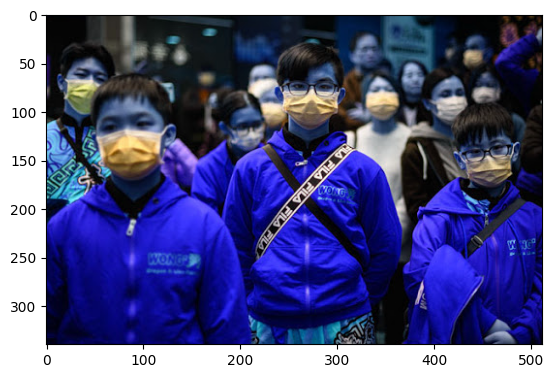

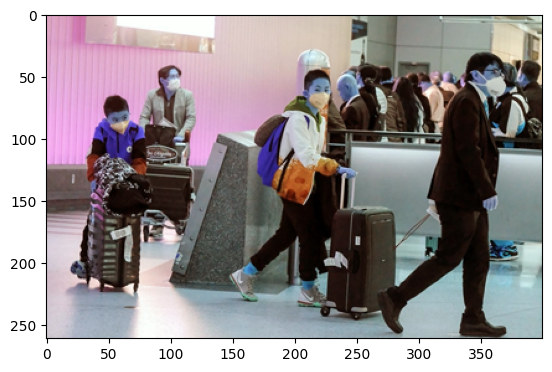

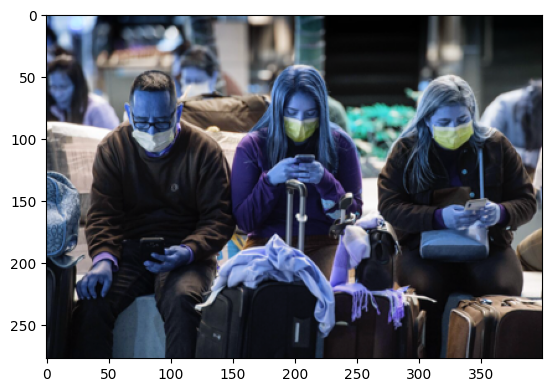

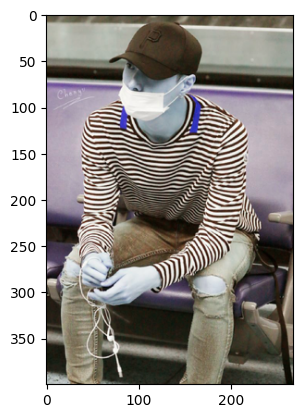

In [12]:
#Sample Visualization

for idx, image in enumerate(os.listdir(img_dir)):
  img = cv2.imread(os.path.join(img_dir, image),1)
  plt.imshow(img)
  plt.show()

  if idx == 3:
    break

In [13]:
# Storing image path

img_file_path = []
for img in os.listdir(img_dir):
  image = cv2.imread(os.path.join(img_dir,img),0) # Reads each img in img_dir and lists the img names in the image folder as greyscale(0)
  img_file_path.append(f'{img}')

In [14]:
# Reading the xml files
df = {'name' : [],
      'label' : [],
      'width' : [],
      'height' : [],
      'xmin' : [],
      'ymin' : [],
      'xmax' : [],
      'ymax' : []}

for idx, anno in enumerate(glob.glob(annotation_dir + '/*.xml')):
  trees = ET.parse(anno)
  root = trees.getroot()
  width, height  = [], []
  for item in root.iter():
    if item.tag == 'size':
      for attr in list(item):
        if attr.tag == 'width':
          width = int(round(float(attr.text)))
        if attr.tag == 'height':
          height = int(round(float(attr.text)))

    if item.tag == 'object':
      for attr in list(item):
        if 'name' in attr.tag:
          label = attr.text
          df['label'] +=[label]
          df['width'] +=[width]
          df['height'] +=[height]
          df['name'] +=[anno.split('/')[-1][0:-4]]

        if 'bndbox' in attr.tag:
          for dim in attr:
            if dim.tag == 'xmin':
              xmin = int(round(float(dim.text)))
              df['xmin'] += [xmin]

            if dim.tag == 'ymin':
              ymin = int(round(float(dim.text)))
              df['ymin'] += [ymin]

            if dim.tag == 'xmax':
              xmax = int(round(float(dim.text)))
              df['xmax'] += [xmax]

            if dim.tag == 'ymax':
              ymax = int(round(float(dim.text)))
              df['ymax'] += [ymax]

In [15]:
df1 = pd.DataFrame(df)
df1.head()

name      label  width  height  xmin  ymin  xmax  ymax
0  maksssksksss120  with_mask    301     400    59   185   183   336
1  maksssksksss512  with_mask    400     280    19    46    40    69
2  maksssksksss512  with_mask    400     280    82    40    99    61
3  maksssksksss512  with_mask    400     280    98    26   132    64
4  maksssksksss512  with_mask    400     280   172    41   198    70

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4072 non-null   object
 1   label   4072 non-null   object
 2   width   4072 non-null   int64 
 3   height  4072 non-null   int64 
 4   xmin    4072 non-null   int64 
 5   ymin    4072 non-null   int64 
 6   xmax    4072 non-null   int64 
 7   ymax    4072 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 254.6+ KB


In [17]:
df1.shape

(4072, 8)

In [18]:
#Labelling
label_map = {'without_mask' : 0,
             'with_mask' : 1,
             'mask_weared_incorrect' : 2}

df1['class'] = df1['label'].map(label_map)

In [19]:
df1.head()

name      label  width  height  xmin  ymin  xmax  ymax  class
0  maksssksksss120  with_mask    301     400    59   185   183   336      1
1  maksssksksss512  with_mask    400     280    19    46    40    69      1
2  maksssksksss512  with_mask    400     280    82    40    99    61      1
3  maksssksksss512  with_mask    400     280    98    26   132    64      1
4  maksssksksss512  with_mask    400     280   172    41   198    70      1

In [20]:
#Splitting data for training

train, test = train_test_split(img_file_path, test_size=0.2, random_state = 3)

train, val = train_test_split(train, test_size=0.15, random_state = 3)

In [21]:
!pip install pillow==10.1.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 12.6 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.1.0 which is incompatible.


In [22]:
# Installing Yolov5 model

!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16249, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 16249 (delta 54), reused 77 (delta 23), pack-reused 16103
Receiving objects: 100% (16249/16249), 15.10 MiB | 15.94 MiB/s, done.
Resolving deltas: 100% (11089/11089), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.8/677.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [23]:

# Creating directories for YOLOv5 data in Colab
base_dir = '/content/yolov5/data'
os.makedirs(os.path.join(base_dir, 'train', 'images'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'train', 'labels'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'val', 'images'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'val', 'labels'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test', 'images'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test', 'labels'), exist_ok=True)


In [24]:
import PIL

def open_image_file(image_items , folder_name):
  for image in image_items:
    img = PIL.Image.open(f'{img_dir}/{image}')
    img1 = img.resize((640,480))
    _ = img1.save(f'/content/yolov5/data/{folder_name}/images/{image}')

open_image_file(train, 'train')
open_image_file(val, 'val')
open_image_file(test, 'test')

In [25]:
# Resizing to new image size

df1['xmin'] = (640/df1['width']) * df1['xmin']
df1['ymin'] = (480/df1['height']) * df1['ymin']
df1['xmax'] = (640/df1['width']) * df1['xmax']
df1['ymax'] = (480/df1['height']) * df1['ymax']
df1.head()

name      label  width  height        xmin        ymin  \
0  maksssksksss120  with_mask    301     400  125.448505  222.000000   
1  maksssksksss512  with_mask    400     280   30.400000   78.857143   
2  maksssksksss512  with_mask    400     280  131.200000   68.571429   
3  maksssksksss512  with_mask    400     280  156.800000   44.571429   
4  maksssksksss512  with_mask    400     280  275.200000   70.285714   

        xmax        ymax  class  
0  389.10299  403.200000      1  
1   64.00000  118.285714      1  
2  158.40000  104.571429      1  
3  211.20000  109.714286      1  
4  316.80000  120.000000      1

In [26]:
df1[['xmin', 'ymin', 'xmax', 'ymax']] = df1[['xmin', 'ymin', 'xmax', 'ymax']].astype('int')

In [27]:
WIDTH = 640
HEIGHT = 480


In [28]:
# COnverting size to adjust midpoint

df1['x_center'] = (df1['xmin']+df1['xmax'])/(2*WIDTH)
df1['y_center'] = (df1['ymin']+df1['ymax'])/(2*HEIGHT)
df1['box_width'] = (df1['xmax']-df1['xmin'])/ WIDTH
df1['box_height'] = (df1['ymax']-df1['ymin'])/ HEIGHT

In [29]:
df1.head()

name      label  width  height  xmin  ymin  xmax  ymax  class  \
0  maksssksksss120  with_mask    301     400   125   222   389   403      1   
1  maksssksksss512  with_mask    400     280    30    78    64   118      1   
2  maksssksksss512  with_mask    400     280   131    68   158   104      1   
3  maksssksksss512  with_mask    400     280   156    44   211   109      1   
4  maksssksksss512  with_mask    400     280   275    70   316   120      1   

   x_center  y_center  box_width  box_height  
0  0.401562  0.651042   0.412500    0.377083  
1  0.073438  0.204167   0.053125    0.083333  
2  0.225781  0.179167   0.042188    0.075000  
3  0.286719  0.159375   0.085938    0.135417  
4  0.461719  0.197917   0.064062    0.104167

In [30]:
df1 = df1.astype(str)

In [31]:
img_file_path[:5]

['maksssksksss373.png',
 'maksssksksss839.png',
 'maksssksksss682.png',
 'maksssksksss484.png',
 'maksssksksss319.png']

In [32]:
def copy_label(label_items, folder_name):
    file_name = [x.split('.')[0] for x in img_file_path]
    for name in file_name:
        data = df1[df1.name == name]
        box_list = []
        for idx in range(len(data)):
            row = data.iloc[idx]
            box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

        text = "\n".join(box_list)
        with open(f'/content/yolov5/data/{folder_name}/labels/{name}.txt', 'w') as file:
            file.write(text)

In [33]:
copy_label(train, 'train')
copy_label(val, 'val')
copy_label(test, 'test')

In [34]:
%cd /content/yolov5/data/train/labels


/content/yolov5/data/train/labels


In [35]:
!cat /content/yolov5/data/train/labels/maksssksksss421.txt


1 0.20234375 0.35833333333333334 0.0796875 0.13333333333333333
1 0.30078125 0.44583333333333336 0.0484375 0.07916666666666666
1 0.503125 0.23125 0.096875 0.15833333333333333
1 0.55546875 0.334375 0.0515625 0.07708333333333334
1 0.803125 0.27395833333333336 0.096875 0.15208333333333332

In [36]:
# Creating yaml file

yaml_file = """train: /content/yolov5/data/train/images
val: /content/yolov5/data/val/images
nc : 3
names: [without_mask, with_mask, mask_weared_incorrect]"""

with open('/content/yolov5/data/data.yaml','w') as f:
  f.write(yaml_file)

In [37]:
!cat /content/yolov5/data/data.yaml

train: /content/yolov5/data/train/images
val: /content/yolov5/data/val/images
nc : 3
names: [without_mask, with_mask, mask_weared_incorrect]

In [38]:
#Training

!python /content/yolov5/train.py --img 640 --epochs 100 --batch 32 --data /content/yolov5/data/data.yaml --weights yolov5s.pt --cache


2024-01-06 14:26:54.204730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-06 14:26:54.204797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-06 14:26:54.206593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/yolov5/data/data.yaml, hyp=../../../data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=../../../data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, mul

In [39]:
# Displaying the performance
from IPython.display import Image as Display

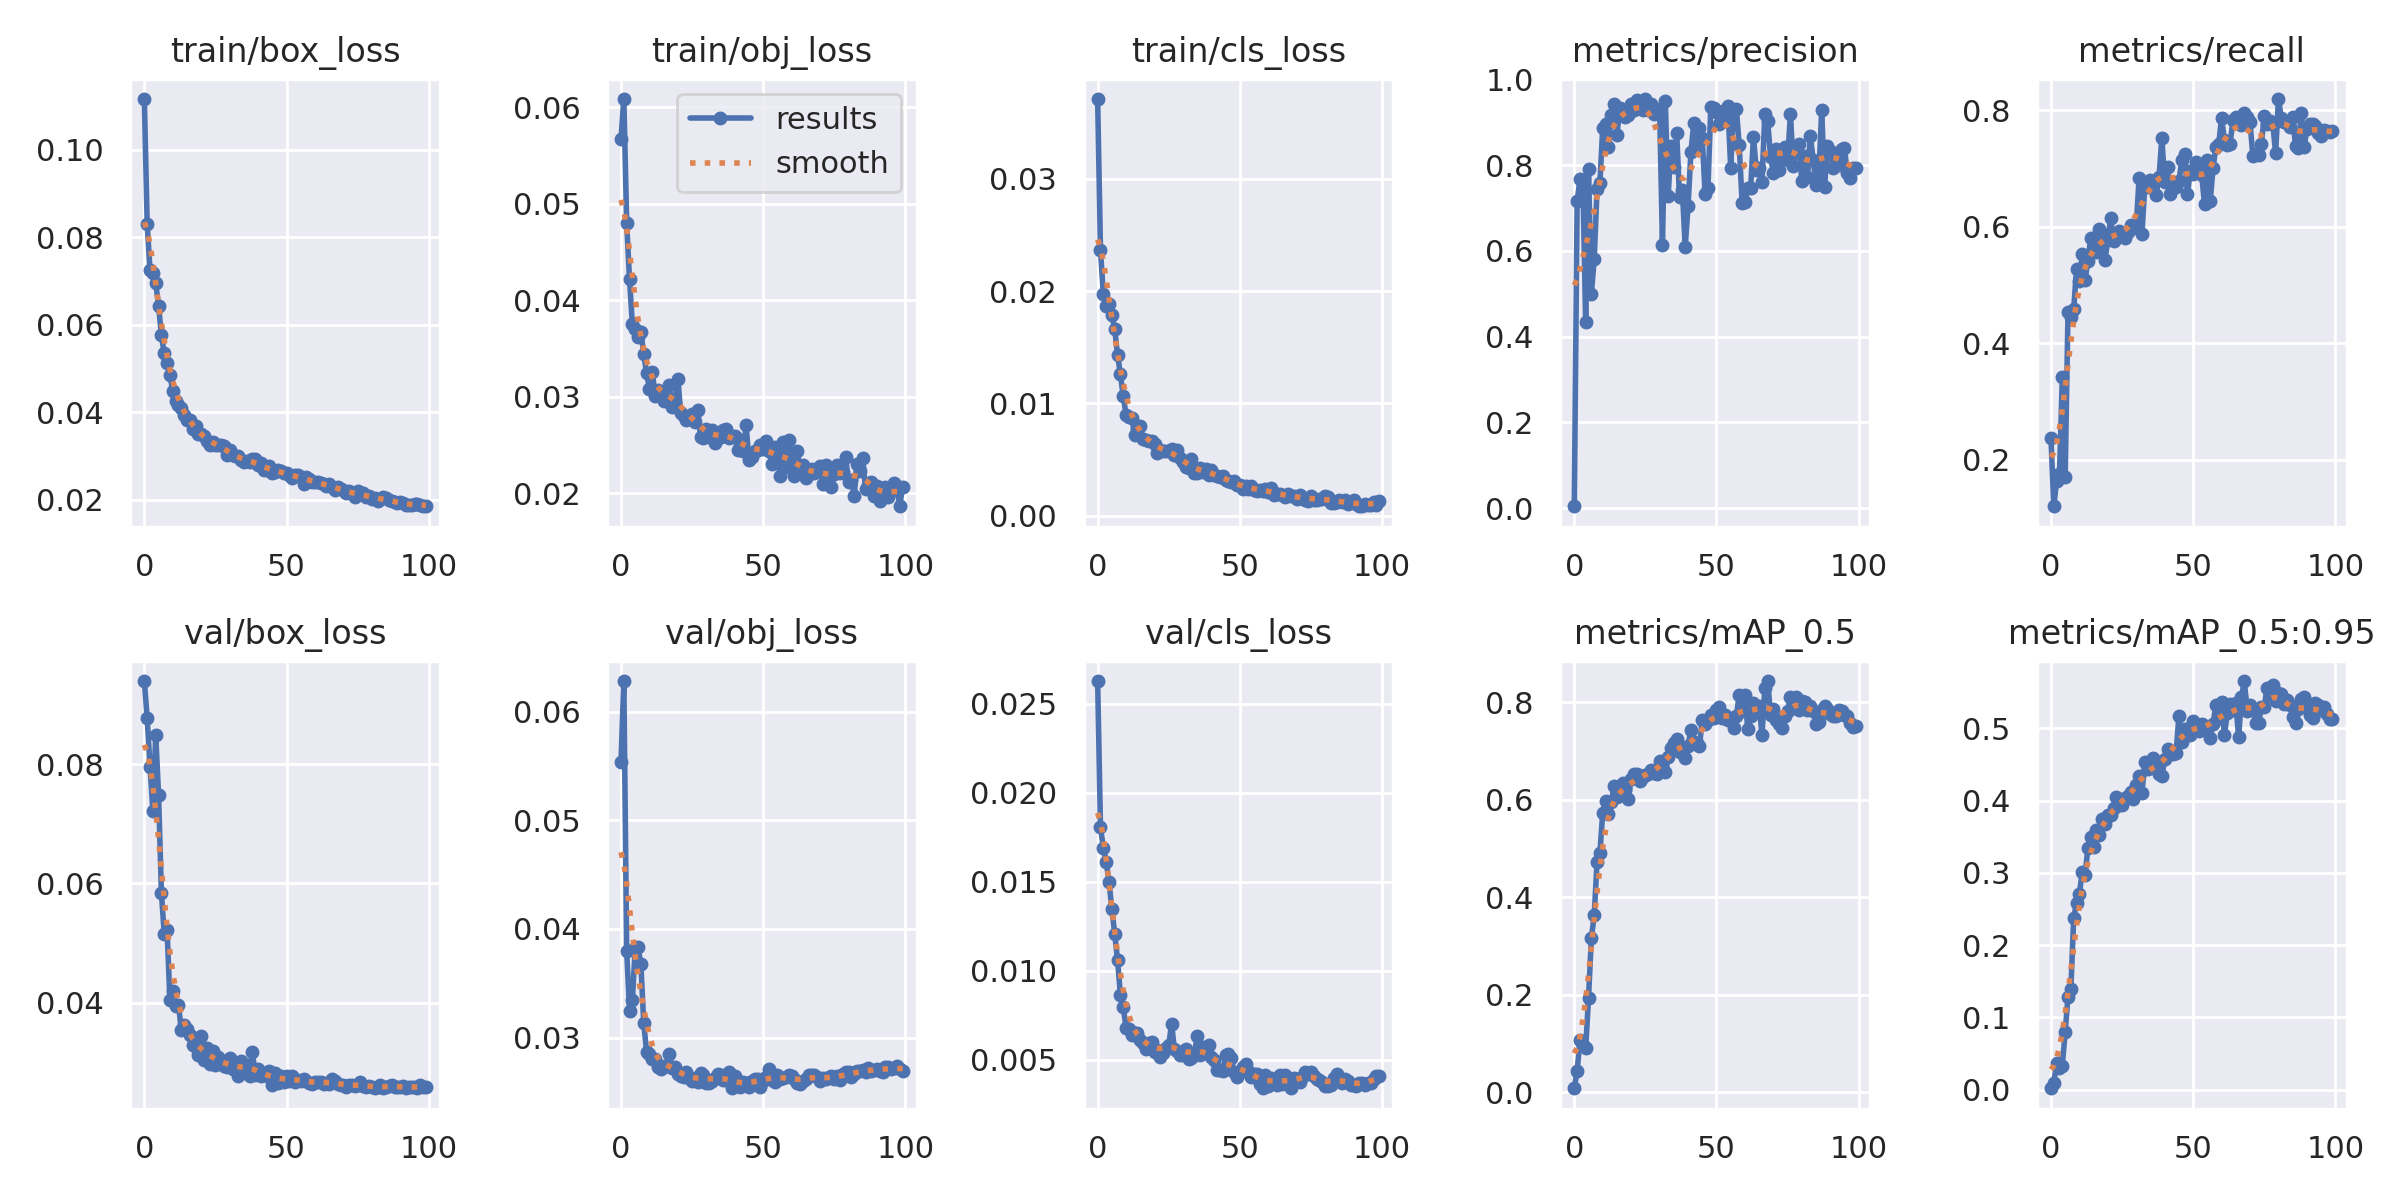

In [40]:
Display(filename='/content/yolov5/runs/train/exp/results.png', width=1080)

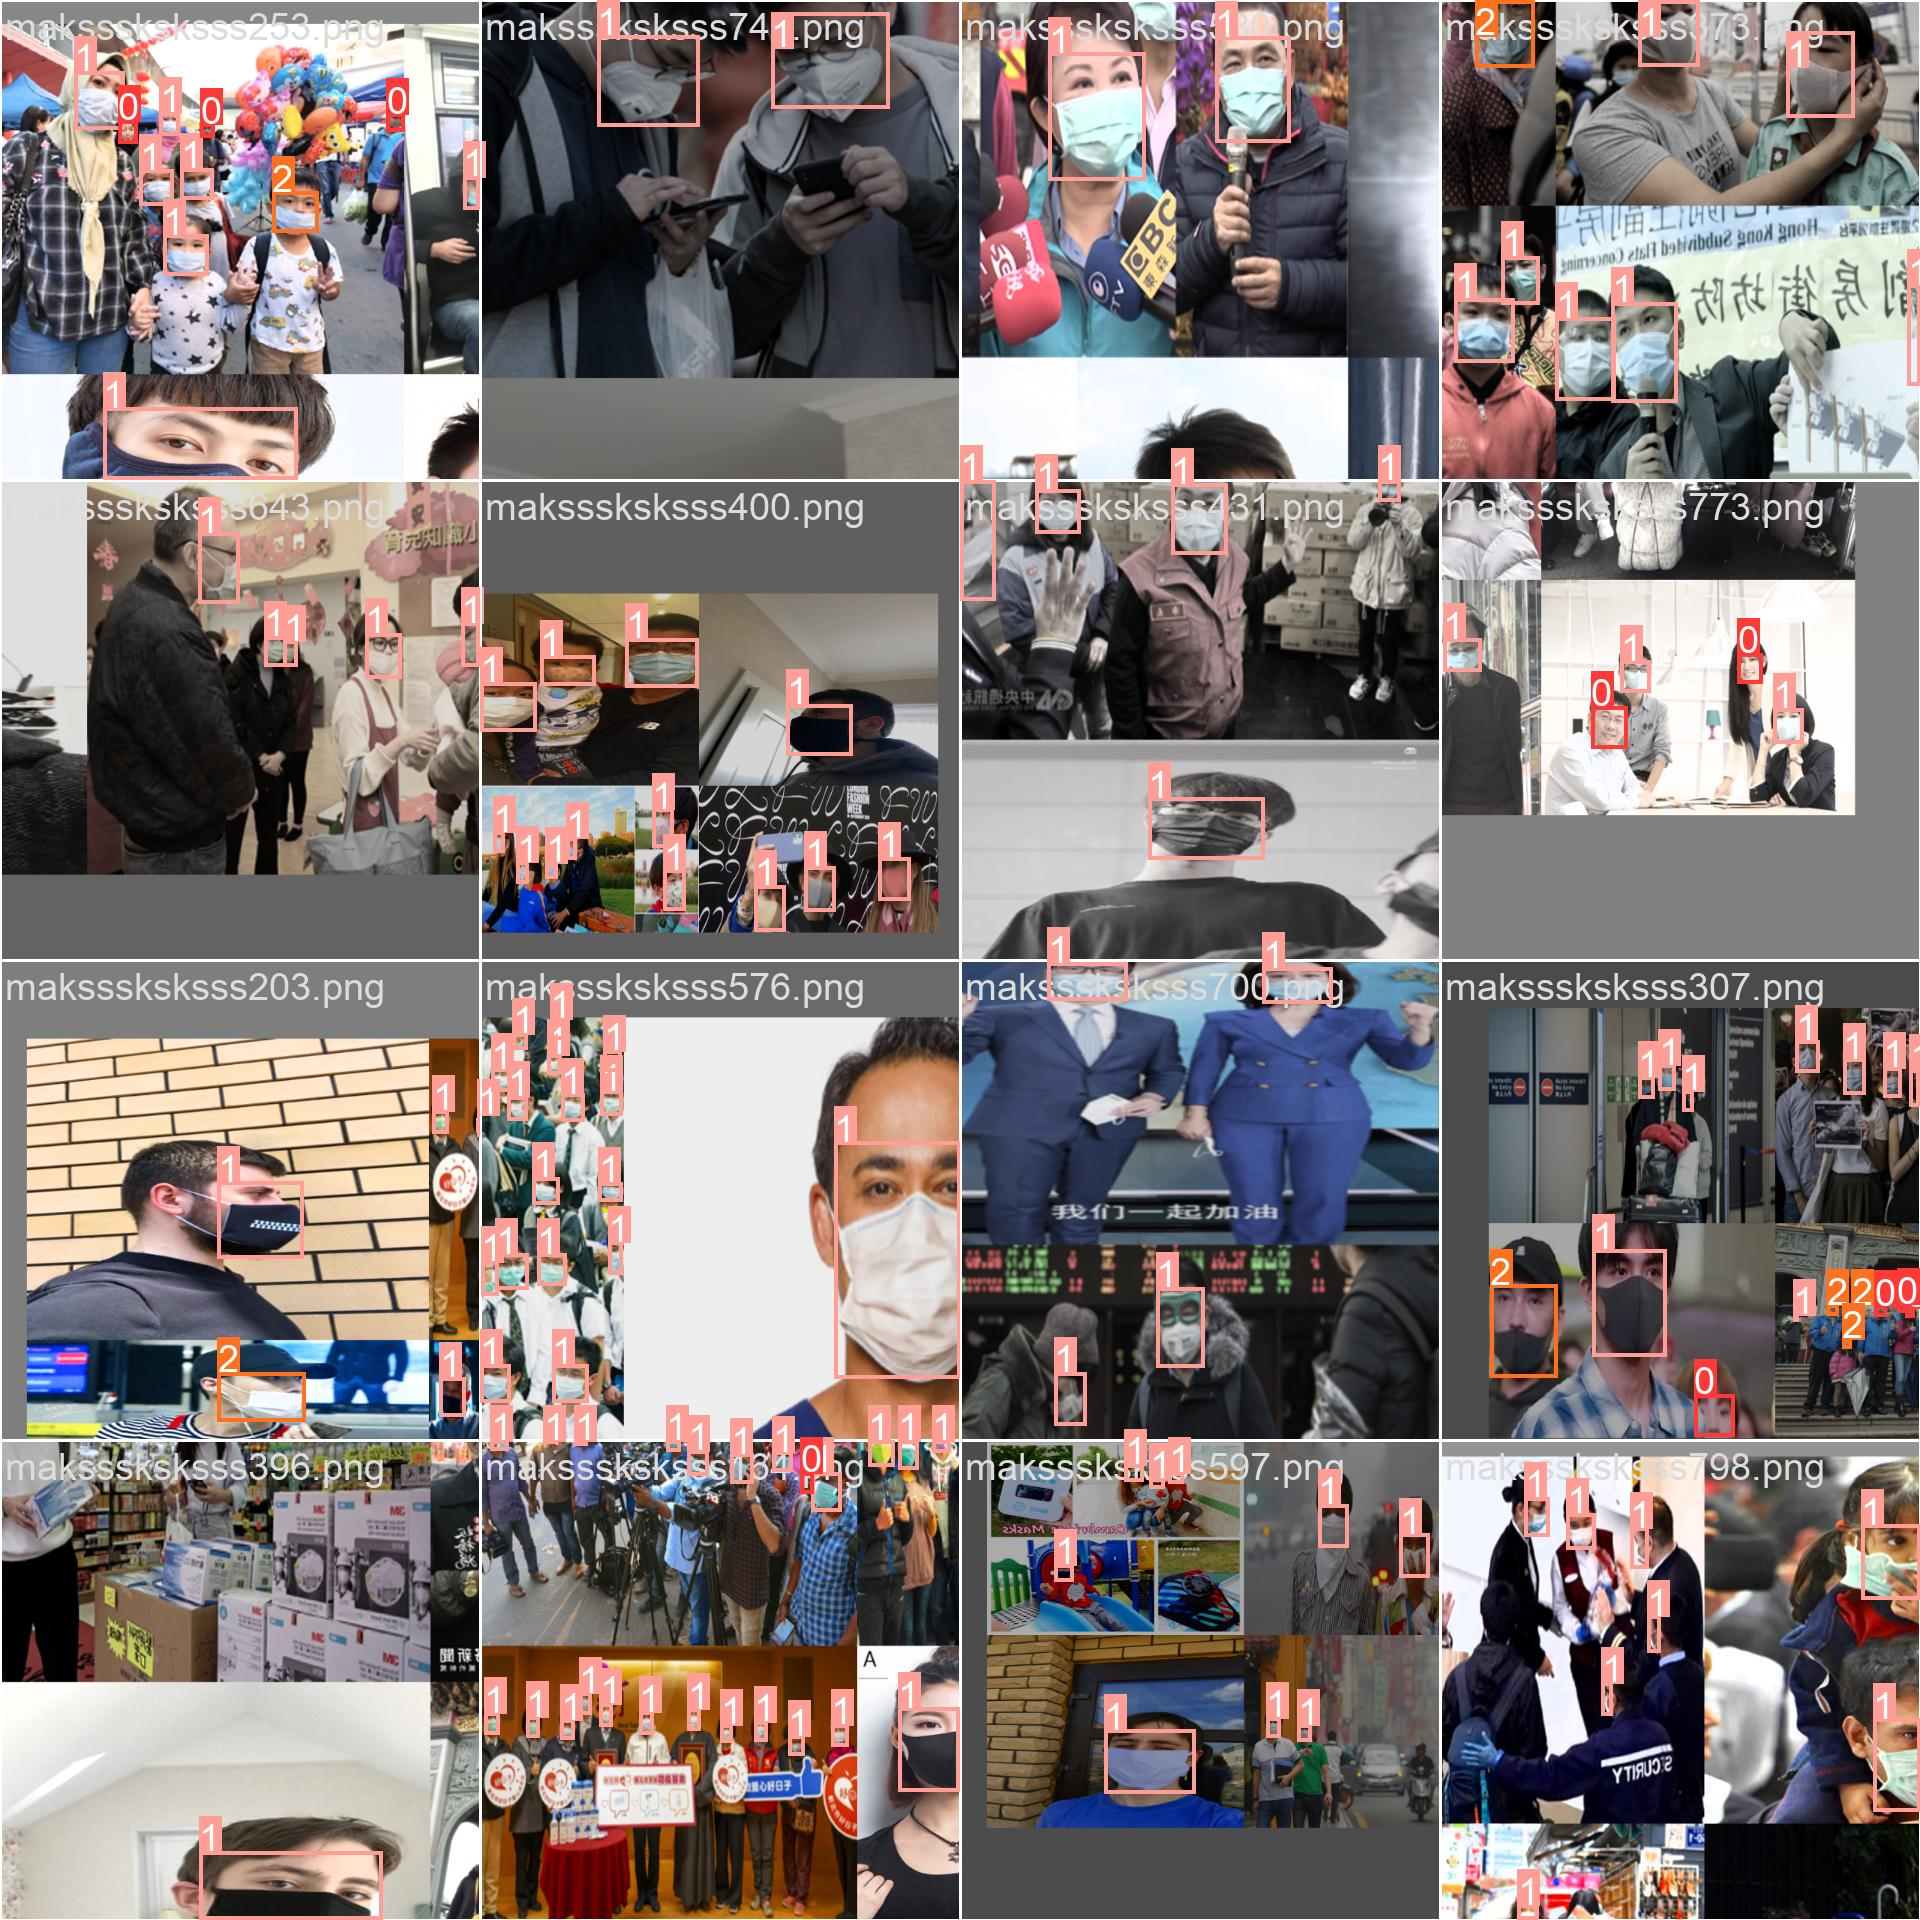

In [41]:
# Displaying Training and Validation
Display(filename='/content/yolov5/runs/train/exp/train_batch0.jpg', width=600)

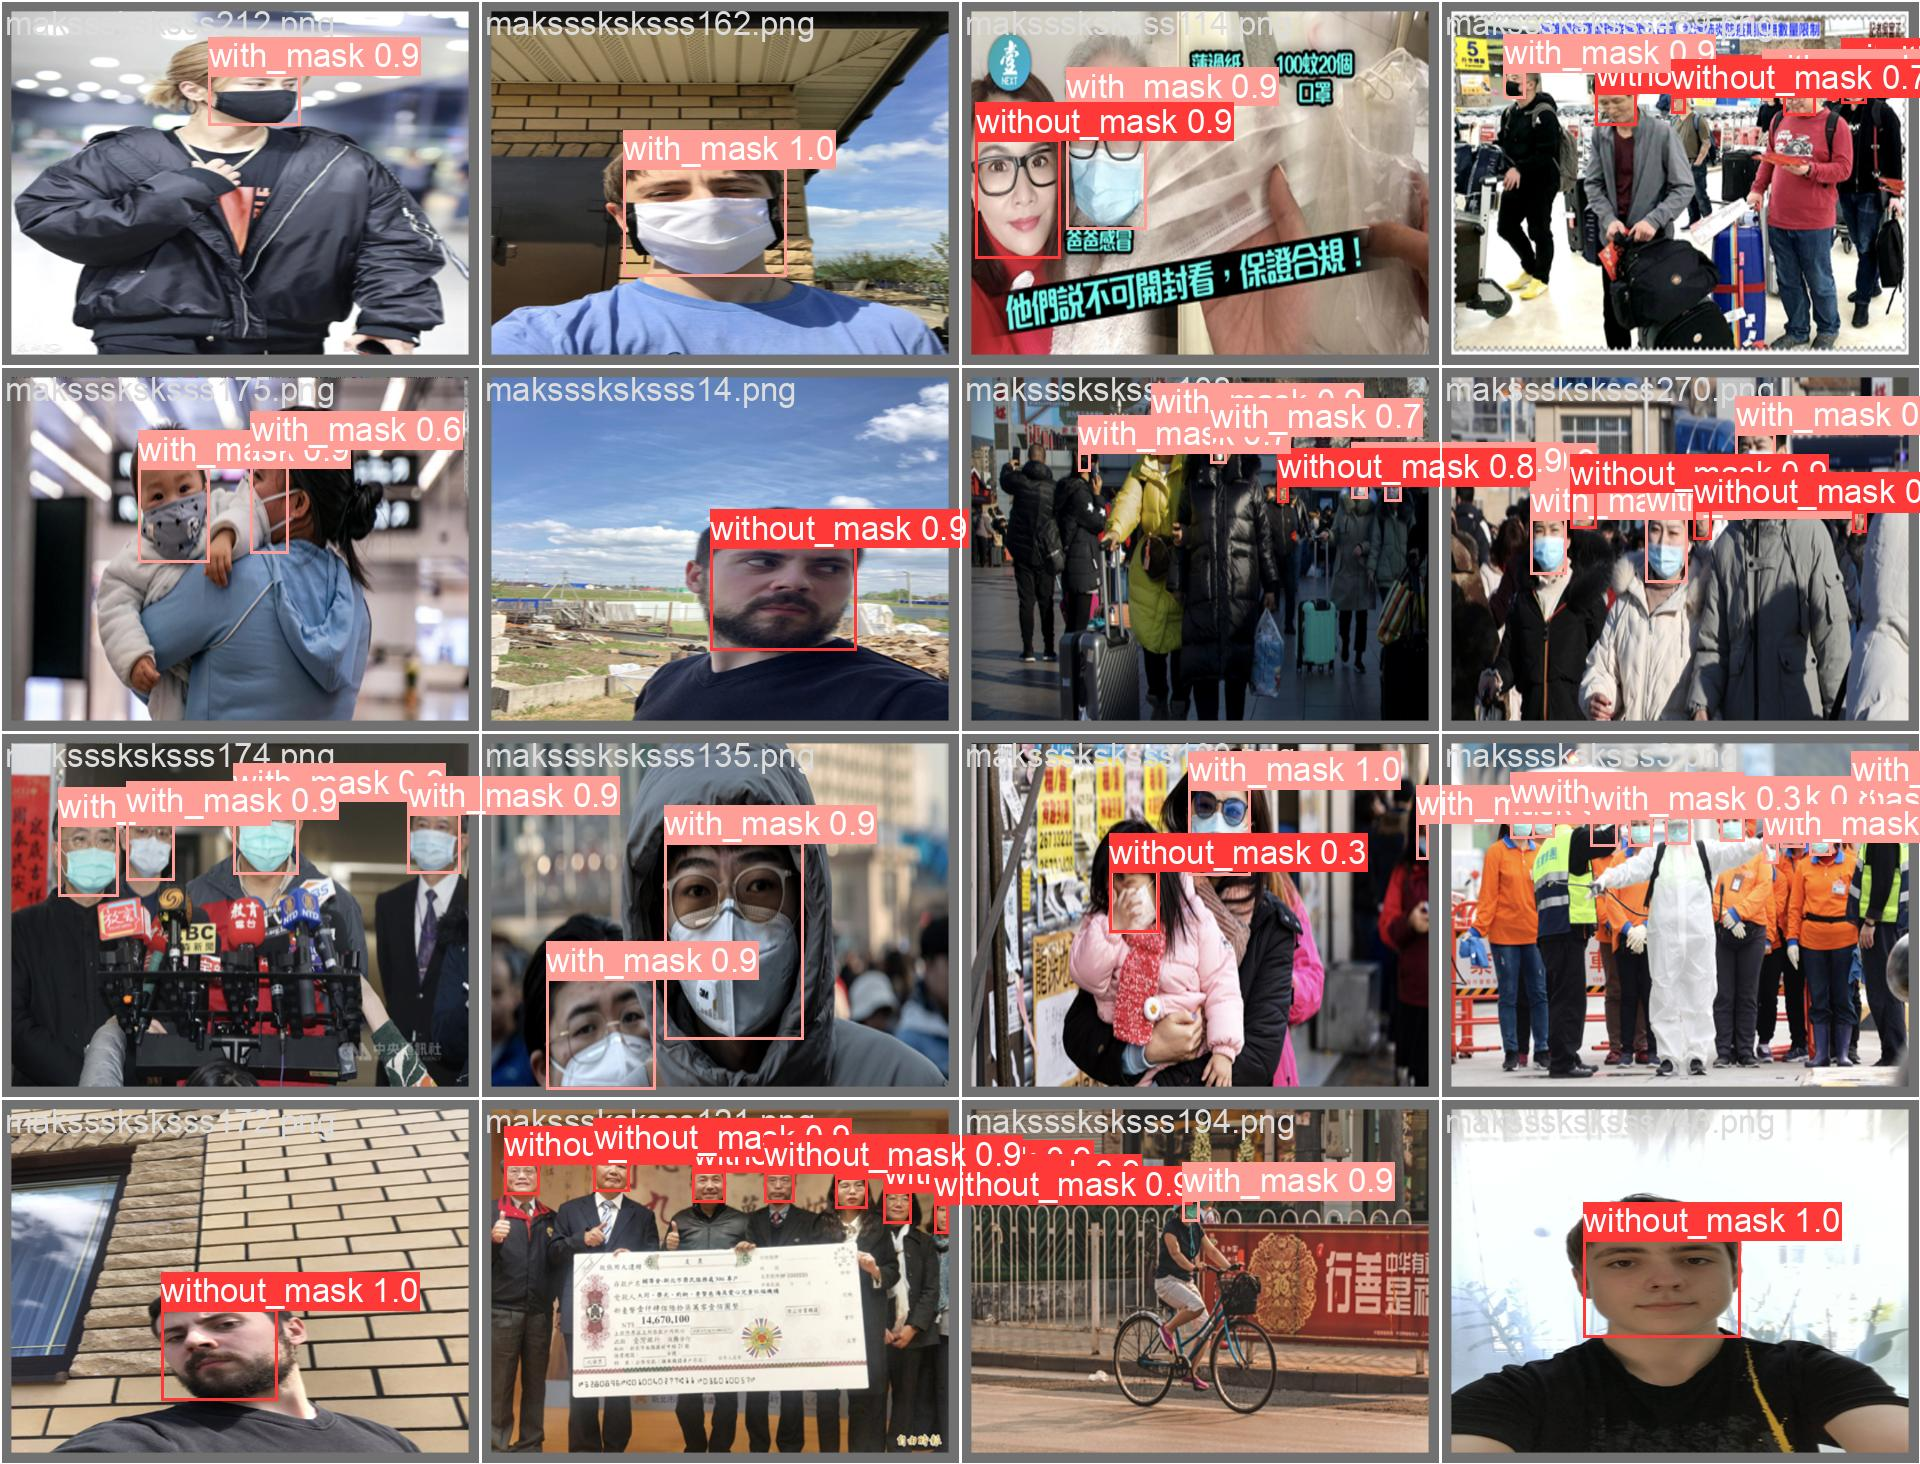

In [42]:
from PIL import Image, ImageOps
Image.open("/content/yolov5/runs/train/exp/val_batch1_pred.jpg")